<a href="https://colab.research.google.com/github/Gooogr/Book_Ian_Pointer_PyTorch_for_DL/blob/master/Ch6.Sounds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q torchaudio

     |████████████████████████████████| 1.9MB 9.0MB/s 


In [2]:
import os
import glob
from pathlib import Path

import math

from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import torchvision
from torchvision import models
from torchsummary import summary

import librosa
import librosa.display

import numpy as np
import IPython.display as display
from collections import Counter
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
# Fix seed
SEED = 42
np.random.seed(seed=SEED)

ESC-50: Dataset for Environmental Sound Classification <br>
https://github.com/karolpiczak/ESC-50 <br>


In [4]:
! git clone https://github.com/karolpiczak/ESC-50.git

Cloning into 'ESC-50'...
remote: Enumerating objects: 4154, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 4154 (delta 10), reused 0 (delta 0), pack-reused 4136
Receiving objects: 100% (4154/4154), 878.78 MiB | 36.25 MiB/s, done.
Resolving deltas: 100% (257/257), done.
Checking out files: 100% (2011/2011), done.


In [5]:
DATASET_PATH = './ESC-50/audio'
DEVICE = 'cuda'
BATCH_SIZE = 64
EPOCHS = 20


Helper functions

In [20]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in range(1, epochs+1):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))
        
def find_lr(model, loss_fn, optimizer, train_loader, init_value=1e-8, final_value=10.0, device="cpu"):
    number_in_epoch = len(train_loader) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    for data in train_loader:
        batch_num += 1
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        # Crash out if loss explodes

        if batch_num > 1 and loss > 4 * best_loss:
            if(len(log_lrs) > 20):
                return log_lrs[10:-5], losses[10:-5]
            else:
                return log_lrs, losses

        # Record the best loss

        if loss < best_loss or batch_num == 1:
            best_loss = loss

        # Store the values
        losses.append(loss.item())
        log_lrs.append(math.log10(lr))

        # Do the backward pass and optimize

        loss.backward()
        optimizer.step()

        # Update the lr for the next step and store

        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr
    if(len(log_lrs) > 20):
        return log_lrs[10:-5], losses[10:-5]
    else:
        return log_lrs, losses

In [19]:
## From repo
# def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
#     for epoch in range(1, epochs+1):
#         training_loss = 0.0
#         valid_loss = 0.0
#         model.train()
#         for batch in train_loader:
#             optimizer.zero_grad()
#             inputs, targets = batch
#             inputs = inputs.to(device)
#             targets = targets.to(device)
#             output = model(inputs)
#             loss = loss_fn(output, targets)
#             loss.backward()
#             optimizer.step()
#             training_loss += loss.data.item() * inputs.size(0)
#         training_loss /= len(train_loader.dataset)
        
#         model.eval()
#         num_correct = 0 
#         num_examples = 0
#         for batch in val_loader:
#             inputs, targets = batch
#             inputs = inputs.to(device)
#             output = model(inputs)
#             targets = targets.to(device)
#             loss = loss_fn(output,targets) 
#             valid_loss += loss.data.item() * inputs.size(0)
#             correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
#             num_correct += torch.sum(correct).item()
#             num_examples += correct.shape[0]
#         valid_loss /= len(val_loader.dataset)

#         print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
#         valid_loss, num_correct / num_examples))
        
# def find_lr(model, loss_fn, optimizer, train_loader, init_value=1e-8, final_value=10.0, device="cpu"):
#     number_in_epoch = len(train_loader) - 1
#     update_step = (final_value / init_value) ** (1 / number_in_epoch)
#     lr = init_value
#     optimizer.param_groups[0]["lr"] = lr
#     best_loss = 0.0
#     batch_num = 0
#     losses = []
#     log_lrs = []
#     for data in train_loader:
#         batch_num += 1
#         inputs, targets = data
#         inputs = inputs.to(device)
#         targets = targets.to(device)
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = loss_fn(outputs, targets)

#         # Crash out if loss explodes

#         if batch_num > 1 and loss > 4 * best_loss:
#             if(len(log_lrs) > 20):
#                 return log_lrs[10:-5], losses[10:-5]
#             else:
#                 return log_lrs, losses

#         # Record the best loss

#         if loss < best_loss or batch_num == 1:
#             best_loss = loss

#         # Store the values
#         losses.append(loss.item())
#         log_lrs.append((lr))

#         # Do the backward pass and optimize

#         loss.backward()
#         optimizer.step()

#         # Update the lr for the next step and store

#         lr *= update_step
#         optimizer.param_groups[0]["lr"] = lr
#     if(len(log_lrs) > 20):
#         return log_lrs[10:-5], losses[10:-5]
#     else:
#         return log_lrs, losses     

# Naive approach: 1D CNN

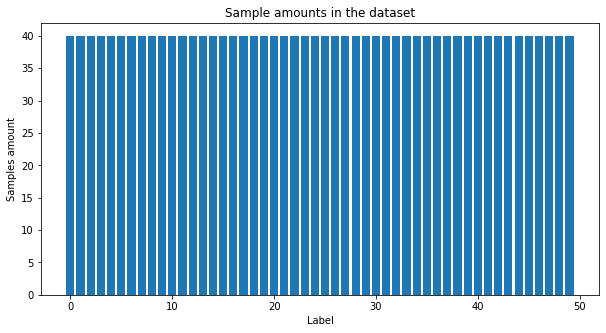

In [7]:
# get complete file path
filenames = glob.glob(os.path.join(DATASET_PATH, '*.wav'))

# extracht sound labels and count them
labels = [int(item.split('-')[-1].replace('.wav', '')) for item in filenames]
sorted_labels_amount = dict(sorted(Counter(labels).items(), key=lambda x: x[0]))

# plot result
plt.figure(figsize=(10, 5))
plt.bar(x=sorted_labels_amount.keys(), height=sorted_labels_amount.values())
plt.title('Sample amounts in the dataset')
plt.xlabel('Label')
plt.ylabel('Samples amount')
plt.show()

Every category distributed equally 👌



In [8]:
# Get random sound sample
random_name = np.random.choice(filenames)
display.Audio(random_name)


### Create data generator

In [9]:
class ESC50(Dataset):
    def __init__(self, dataset_path, subset_name=None):
        # Create generator with .wav file pathes
        files = Path(dataset_path).glob('*.wav')
        
        # Set dataset type dict
        subset_type = {1: 'train',
                       2: 'train',
                       3: 'train',
                       4: 'valid',
                       5: 'test'}
        
        # Iterate through file path and get list of (file path, label)
        # File name example: 5-198278-B-7.wav'
        extract_label = lambda x: int(x.split('-')[-1].replace('.wav', ''))
        self.items = [(str(f_path), extract_label(f_path.name)) for f_path in files \
                      if subset_name == subset_type[int(f_path.name[0])]]
        # Get length of items list
        self.length = len(self.items)
        
    def __getitem__(self, index):
        filename, label = self.items[index]
        audio_tensor, _ = torchaudio.load(filename)
        return (audio_tensor, label)
    
    def __len__(self):
        return self.length

In [10]:
train_loader = DataLoader(ESC50(DATASET_PATH, subset_name='train'), batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(ESC50(DATASET_PATH, subset_name='valid'), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(ESC50(DATASET_PATH, subset_name='test'), batch_size=BATCH_SIZE, shuffle=True)

In [11]:
## Check loader sample. Sample size - [64, 1, 220500]
# next(iter(train_loader))


### Simple AudioNet CNN

In [12]:
class AudioNet(nn.Module):
    def __init__(self):
        super(AudioNet, self).__init__()
        self.conv1 = nn.Conv1d(100, 128, kernel_size=5, stride=4)
        self.bn1 = nn.BatchNorm1d(128)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(128, 128, 3)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(128, 256, 3)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(256, 512, 3)
        self.bn4 = nn.BatchNorm1d(512)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(512, 50)

    def forward(self, x):
        x = x.unsqueeze(-1).view(-1, 100, 2205)
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = x.squeeze(-1)
        x = self.fc1(x)
        return x    

In [21]:
audionet = AudioNet()
audionet.to(DEVICE);

Print model summary

In [22]:
summary(audionet, input_size=(64, 1, 220500))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 128, 551]          64,128
       BatchNorm1d-2             [-1, 128, 551]             256
         MaxPool1d-3             [-1, 128, 137]               0
            Conv1d-4             [-1, 128, 135]          49,280
       BatchNorm1d-5             [-1, 128, 135]             256
         MaxPool1d-6              [-1, 128, 33]               0
            Conv1d-7              [-1, 256, 31]          98,560
       BatchNorm1d-8              [-1, 256, 31]             512
         MaxPool1d-9               [-1, 256, 7]               0
           Conv1d-10               [-1, 512, 5]         393,728
      BatchNorm1d-11               [-1, 512, 5]           1,024
        MaxPool1d-12               [-1, 512, 1]               0
           Linear-13                   [-1, 50]          25,650
Total params: 633,394
Trainable params:

Save model weight and find optimal learning rate

In [26]:
# %%time
# torch.save(audionet.state_dict(), "audionet.pth")
# optimizer = optim.Adam(audionet.parameters(), lr=0.001)
# logs, losses = find_lr(audionet, nn.CrossEntropyLoss(), optimizer, train_loader, device=DEVICE)


In [25]:
# plt.plot(logs, losses)

**WTF?**

In [ ]:
# logs

# Better idea - spectrograms

### Prepare data generator

Visualize random sample from the previous stage

In [27]:
sample_data, sr = librosa.load(random_name, sr=None)
spectrogram = librosa.feature.melspectrogram(sample_data, sr=sr)

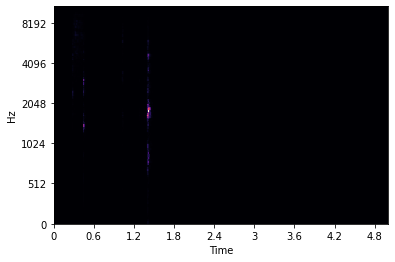

In [28]:
librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='mel');

Convert to logarithmic scale

In [29]:
log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

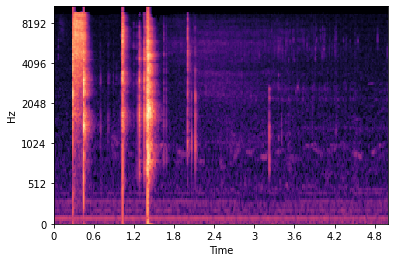

In [30]:
librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel');

Nice! Let's precompute spectogram for every dataset object

In [31]:
spectrogram_folder = "./ESC-50/images"

try:
    os.mkdir(spectrogram_folder)
except OSError:
    print ("Creation of the directory %s failed" % spectrogram_folder)
else:
    print ("Successfully created the directory %s " % spectrogram_folder)

Successfully created the directory ./ESC-50/images 


In [32]:
def precompute_and_save_spectrogram(file_path, saving_dir, dpi=50):
    # Compute spectrogram
    audio_tensor, sample_rate = librosa.load(file_path, sr=None)
    spectrogram = librosa.feature.melspectrogram(audio_tensor, sr=sr)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    # Get file name
    f_name = file_path.name
    # Save result   
    fig,ax = plt.subplots(1)
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
    librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel');
    plt.close() # hide image output
    fig.savefig(os.path.join(saving_dir, "{}_{}.png".format(f_name, dpi)), dpi=dpi)

In [33]:
# 2000 objects, ~5 min in google colab
files = Path(DATASET_PATH).glob('*.wav')
for file_path in tqdm(files):
    precompute_and_save_spectrogram(file_path, spectrogram_folder)

2000it [05:45,  5.79it/s]


In [34]:
class PrecomputedESC50(Dataset):
    def __init__(self, dataset_path, subset_name=None, transforms=None):
        # Create generator with .png file pathes
        files = Path(dataset_path).glob('*.png')
        
        # Set dataset type dict
        subset_type = {1: 'train',
                       2: 'train',
                       3: 'train',
                       4: 'valid',
                       5: 'test'}
        # Iterate through file path and get list of (file path, label)
        # File name example: 1-137-A-32.wav_50.png
        extract_label = lambda x: int(x.split('-')[-1].split('.')[0])
        self.items = [(str(f_path), extract_label(f_path.name)) for f_path in files \
                      if subset_name == subset_type[int(f_path.name[0])]]
        # Get length of items list
        self.length = len(self.items)
        
        # Apply image transformers
        if transforms is None:
            self.transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
        else:
            self.transforms = transforms
        
    def __getitem__(self, index):
        filename, label = self.items[index]
        img = Image.open(filename).convert('RGB')
#         print(filename)
        return (self.transforms(img), label)
    
    def __len__(self):
        return self.length    

In [35]:
train_loader = DataLoader(PrecomputedESC50(spectrogram_folder, subset_name='train'), batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(PrecomputedESC50(spectrogram_folder, subset_name='valid'), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(PrecomputedESC50(spectrogram_folder, subset_name='test'), batch_size=BATCH_SIZE, shuffle=True)

In [36]:
sample = next(iter(train_loader))[0][0] 
print(sample.shape)

torch.Size([3, 200, 300])


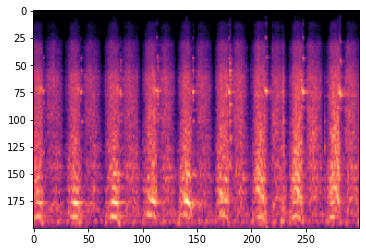

In [37]:
plt.imshow(np.moveaxis(np.array(sample[0:3, :, :]), 0, -1)); # >_<

### Setting up pre-trained ResNet50

In [38]:
spec_resnet = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [39]:
# for param in spec_resnet.parameters():
#     param.requires_grad = False

In [40]:
spec_resnet.fc = nn.Sequential(nn.Linear(spec_resnet.fc.in_features, 500),
                               nn.ReLU(),
                               nn.Dropout(),
                               nn.Linear(500, 50))

In [41]:
transformer = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                              torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                               std=[0.229, 0.224, 0.225])])

esc50pre_train = PrecomputedESC50(spectrogram_folder, 
                                  subset_name='train', 
                                  transforms=transformer)
esc50pre_valid = PrecomputedESC50(spectrogram_folder, 
                                  subset_name='valid', 
                                  transforms=transformer)

esc50_train_loader = DataLoader(esc50pre_train, batch_size=BATCH_SIZE, shuffle=True)
esc50_valid_loader = DataLoader(esc50pre_valid, batch_size=BATCH_SIZE, shuffle=True)

In [42]:
# # Skip lr finding part and unfrozen layers
# for param in spec_resnet.parameters():
#     param.requires_grad = True

In [53]:
spec_resnet.to(DEVICE) 
optimizer = optim.Adam(spec_resnet.parameters(), lr=1e-5)

In [56]:
train(spec_resnet, optimizer, nn.CrossEntropyLoss(), 
      esc50_train_loader, esc50_valid_loader, 
      epochs=20, device=DEVICE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1, Training Loss: 3.91, Validation Loss: 3.88, accuracy = 0.03
Epoch: 2, Training Loss: 3.83, Validation Loss: 3.83, accuracy = 0.07
Epoch: 3, Training Loss: 3.76, Validation Loss: 3.77, accuracy = 0.16
Epoch: 4, Training Loss: 3.68, Validation Loss: 3.71, accuracy = 0.22
Epoch: 5, Training Loss: 3.59, Validation Loss: 3.64, accuracy = 0.28
Epoch: 6, Training Loss: 3.50, Validation Loss: 3.55, accuracy = 0.31
Epoch: 7, Training Loss: 3.39, Validation Loss: 3.45, accuracy = 0.35
Epoch: 8, Training Loss: 3.25, Validation Loss: 3.34, accuracy = 0.40
Epoch: 9, Training Loss: 3.15, Validation Loss: 3.22, accuracy = 0.44
Epoch: 10, Training Loss: 3.00, Validation Loss: 3.11, accuracy = 0.45
Epoch: 11, Training Loss: 2.86, Validation Loss: 2.99, accuracy = 0.47
Epoch: 12, Training Loss: 2.74, Validation Loss: 2.87, accuracy = 0.48
Epoch: 13, Training Loss: 2.59, Validation Loss: 2.76, accuracy = 0.50
Epoch: 14, Training Loss: 2.45, Validation Loss: 2.65, accuracy = 0.53
Epoch: 15, Trai